In [12]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [13]:


DATA_DIR ="./data/validated/"
v = VERIS(json_dir=DATA_DIR, verbose=True)
vdf = v.json_to_df(keep_raw=True)
print(vdf.shape)


Found 8323 json files.
Loading schema
Loading JSON files to DataFrame.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8323/8323 [00:02<00:00, 3188.68it/s]


Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:22<00:00,  7.85it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame
(8323, 2347)


##### v is a VERIS object. vdf contains the actual data. 

[Good StackOverflow Answer on working with Dataframes vvv](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

(4690, 2347)


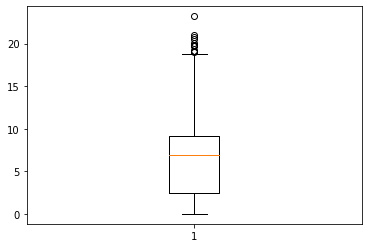

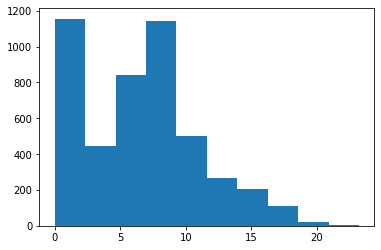

In [16]:
import matplotlib.pyplot as plt
vdf.rename(columns={"attribute.confidentiality.data_total": "records_lost"}, inplace=True)
vdf
vdf_loss = vdf.dropna(subset=["records_lost"])
plt.boxplot(np.log(vdf_loss["records_lost"]))
print(vdf_loss.shape)
plt.show()
plt.hist(np.log(vdf_loss["records_lost"]))
plt.show()

Total Records Breached, Log Normalized

In [7]:
vdf_loss
# plt.hist(vdf_loss['victim.employee_count'])
# df_action = vdf_loss.loc[:, vdf_loss.columns.str.startswith('action')]
# df_action


,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.XPF,victim.revenue.iso_currency_code.YER,victim.revenue.iso_currency_code.ZAR,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id
0,False,False,False,False,True,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,MO,United States Department of Veterans Affairs
4,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,PA,United States Department of Veterans Affairs
5,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,PA,United States Department of Veterans Affairs
8,False,False,False,False,False,True,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,CA,Sutter Medical Foundation
9,False,False,False,False,True,True,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,WI,Wisconsin Department of Health Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8312,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,IL,Silver Cross Hospital
8313,False,False,False,False,False,True,False,False,NaN,False,...,False,False,False,False,False,8.0,NaN,"[Northstar Healthcare Surgery Center, Microsu...",TX,EqualizeRCM Services
8317,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,Al Zahra Private Medical Centre
8321,False,False,False,False,False,True,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,Walking on Air Clinic


In [80]:
df_final = df_action.iloc[:, :7]
df_bugs = vdf_loss[vdf_loss['action.Hacking'] | vdf_loss['action.Malware']]
# print(df_bugs.shape)



In [81]:
indices = list(df_bugs.index)
bugs = [False] * df_final.shape[0]
for i in indices:
    bugs[i] = True

In [82]:
df_final['action.Bugs'] = bugs
df_final


,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Bugs
0,False,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False
4,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...
4685,False,True,False,False,False,False,False,False
4686,False,False,False,False,False,True,False,False
4687,False,False,True,False,False,False,False,True
4688,False,False,False,False,False,True,False,False


In [9]:
#Creates a smaller table for ease of running
# N = 1000
# sample = np.random.choice(8323, N)
# df_short = df_final.iloc[sample,:].reset_index().iloc[:,1:]


# Maybe we should id the column here in the future so we can refer to the original table values

In [10]:
# impactful_df = vdf[vdf['impact.overall_rating.Insignificant'] | vdf['impact.overall_rating.Distracting'] | vdf['impact.overall_rating.Painful'] | vdf['impact.overall_rating.Catastrophic'] | vdf['impact.overall_rating.Damaging']].reindex()
# reset_impactful_df = impactful_df.reset_index(drop=True) #Resets the indicies
# impactful_df_bugs = reset_impactful_df[reset_impactful_df['action.Hacking'] | reset_impactful_df['action.Malware']]
# impactful_df_bugs


,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.XPF,victim.revenue.iso_currency_code.YER,victim.revenue.iso_currency_code.ZAR,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id
1,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,CA,Uber
5,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-MI,Adrian College
6,False,False,True,False,False,False,True,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-IA,Virginia Gay Hospital
7,False,False,False,True,False,False,False,False,NaN,False,...,False,False,False,False,False,1.0,The dentist offices who were compromised could...,[Digital Dental Record],US-WI,PerCSoft
13,False,False,True,True,False,False,True,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,CA-ON,Michael Garron Hospital
14,False,False,True,False,True,True,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,WI,Brinks Security
17,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,Society of Information Risk Analysts
18,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,VA,"Albemarle County, VA"
20,False,False,False,True,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-CT,Wolcott school district
23,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,False,NaN,NaN,NaN,US-KY,Elmcroft Senior Living


In [11]:
indices = list(impactful_df_bugs.index)
bugs = [False] * impactful_df.shape[0]
for i in indices:
    bugs[i] = True
overall_rating = reset_impactful_df.loc[:, reset_impactful_df.columns.str.startswith('impact.overall_rating')]
df_final = reset_impactful_df.iloc[:, :7]
df_final['action.Bugs'] = bugs
result = pd.concat([df_final,overall_rating], axis=1, sort=False)
result = result.iloc[:,:13]
result 

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Bugs,impact.overall_rating.Catastrophic,impact.overall_rating.Damaging,impact.overall_rating.Distracting,impact.overall_rating.Insignificant,impact.overall_rating.Painful
0,False,True,False,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,False,True,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,False,False,True,False,False,False,True,True,False,False,False,False,True
112,False,False,True,False,False,False,False,True,False,False,True,False,False
113,False,False,False,False,False,False,True,False,False,False,True,False,False
114,False,False,False,True,False,False,False,True,False,False,False,False,True


In [13]:
#result['outcome'] 

#imp_name = "impact.overall_rating"
#result.apply(outcome: lambda outcome + 1, axis = 1)
#idxs = range(len(result))
#for i in idxs:
#    for rank in ranking.keys():
#        if result.[i][rank]:
#            print(rank) = 
#     for 
#             print result[rank]
# ranking

In [1]:
# impact = [0] * result.shape[0]
# for i in range(result.shape[0]):
#     if(result.loc[i, 'impact.overall_rating.Insignificant']):
#         impact[i] = 1
#     elif(result.loc[i, 'impact.overall_rating.Distracting']):
#         impact[i] = 2
#     elif(result.loc[i, 'impact.overall_rating.Painful']):
#         impact[i] = 3
#     elif(result.loc[i, 'impact.overall_rating.Damaging']):
#         impact[i] = 4
#     elif(result.loc[i, 'impact.overall_rating.Catastrophic']):
#         impact[i] = 5
# result['action.Impact'] = impact #Impact rating column is named 'action.Impact'
# result = result.loc[:, result.columns.str.startswith('action')] #CURRENT FINAL DATAFRAME
# result
# import matplotlib.pyplot as plt
# plt.hist(result["action.Impact"])

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets, dowhy.plotter 

ModuleNotFoundError: No module named 'dowhy'

In [ ]:
import sys
print(sys.version)

In [ ]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_samples=10000,
        treatment_is_binary=True)
df = data["df"]
df

In [ ]:
#Create causal model with instrumental
model = CausalModel(
    data = result,
    treatment = 'action.Bugs',
    outcome = 'records_lost',
    graph = './NetworkXTest/test.gml',
    logging_level = logging.INFO
)
#model.view_model(layout="dot")

In [ ]:
model.view_model()

In [ ]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

In [ ]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, result['action.Bugs'], result['action.Impact'])
# I think the issue is our data isn't giving us a linear plot... this is linear regression after all

In [ ]:
print("DoWhy estimate is " + str(estimate.value))
rvar = 1 if np.random.uniform() >0.5 else 0
print ("Actual true causal effect was {0}".format(rvar))

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

## Method 1: Stratification

In [ ]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

## Method 2: Matching

In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))